In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import random, os, warnings, math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers, losses, metrics, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from transformers import TFAutoModelForSequenceClassification, TFAutoModel, AutoTokenizer


def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
sns.set(style='whitegrid')
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 150)

In [3]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

REPLICAS: 1


In [4]:
train_filepath = '/kaggle/input/commonlitreadabilityprize/train.csv'
test_filepath = '/kaggle/input/commonlitreadabilityprize/test.csv'

train = pd.read_csv(train_filepath)
test = pd.read_csv(test_filepath)

print(f'Train samples: {len(train)}')
display(train.head())

print(f'Test samples: {len(test)}')
display(test.head())

# removing unused columns
train.drop(['url_legal', 'license'], axis=1, inplace=True)
test.drop(['url_legal', 'license'], axis=1, inplace=True)

Train samples: 2834


,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,"When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landsca...",-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewhat silent, her eyes resting on Dolly with a wistful, uncertain expression. She wanted to give the ch...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as quickly as it came, and two days after their sleigh ride there was scarcely a vestige of white on the...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,"And outside before the palace a great garden was walled round, filled full of stately fruit-trees, gray olives and sweet figs, and pomegranates, p...",-1.054013,0.450007
4,37c1b32fb,NaN,NaN,"Once upon a time there were Three Bears who lived together in a house of their own in a wood. One of them was a Little, Small, Wee Bear; and one w...",0.247197,0.510845


Test samples: 7


,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would keep a bright light burning in the upper story to guide me on my course. On a clear night this light w...
1,f0953f0a5,NaN,NaN,"Dotty continued to go to Mrs. Gray's every night with the milk. Sometimes Katie went with her, and then they always paused a while under the acorn..."
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greeted the eyes of Captain Raymond and his son as they entered the parlor of the adjacent cottage.\nIt wa...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent cell divides into two or more daughter cells. Cell division usually occurs as part of a larger cell...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolving of defects that prevent correct operation of computer software or a system. Debugging tends to b...


**Model Params**

In [5]:
BATCH_SIZE = 8 * REPLICAS
LEARNING_RATE = 1e-5 * REPLICAS
EPOCHS = 35
ES_PATIENCE = 7
PATIENCE = 2
N_FOLDS = 5
SEQ_LEN = 256 #300
BASE_MODEL = '/kaggle/input/huggingface-roberta/roberta-base/'

 **Auxiliary functions**

In [6]:
def custom_standardization(text):
    text = text.lower()
    text = text.strip()
    return text

def sample_target(features, target):
    mean, stddev = target
    sampled_target = tf.random.normal([], mean=tf.cast(mean, dtype=tf.float32), 
                                      stddev=tf.cast(stddev, dtype=tf.float32), dtype=tf.float32)
    
    return (features, sampled_target)

def get_dataset(pandas_df, tokenizer, labeled=True, ordered=False, repeated=False, 
                is_sampled=False, batch_size=32, seq_len=128):
    """
        Return a Tensorflow dataset ready for training or inference.
    """
    text = [custom_standardization(text) for text in pandas_df['excerpt']]
    
    # Tokenize inputs
    tokenized_inputs = tokenizer(text, max_length=seq_len, truncation=True, 
                                 padding='max_length', return_tensors='tf')
    
    if labeled:
        dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': tokenized_inputs['input_ids'], 
                                                      'attention_mask': tokenized_inputs['attention_mask']}, 
                                                      (pandas_df['target'], pandas_df['standard_error'])))
        if is_sampled:
            dataset = dataset.map(sample_target, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = tf.data.Dataset.from_tensor_slices({'input_ids': tokenized_inputs['input_ids'], 
                                                      'attention_mask': tokenized_inputs['attention_mask']})
        
    if repeated:
        dataset = dataset.repeat()
    if not ordered:
        dataset = dataset.shuffle(1024)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

def plot_metrics(history):
    metric_list = list(history.keys())
    size = len(metric_list)//2
    fig, axes = plt.subplots(size, 1, sharex='col', figsize=(20, size * 5))
    axes = axes.flatten()
    
    for index in range(len(metric_list)//2):
        metric_name = metric_list[index]
        val_metric_name = metric_list[index+size]
        axes[index].plot(history[metric_name], label='Train %s' % metric_name)
        axes[index].plot(history[val_metric_name], label='Validation %s' % metric_name)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric_name)

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()

**EDA**

In [7]:
display(train.head())

,id,excerpt,target,standard_error
0,c12129c31,"When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landsca...",-0.340259,0.464009
1,85aa80a4c,"All through dinner time, Mrs. Fayre was somewhat silent, her eyes resting on Dolly with a wistful, uncertain expression. She wanted to give the ch...",-0.315372,0.480805
2,b69ac6792,"As Roger had predicted, the snow departed as quickly as it came, and two days after their sleigh ride there was scarcely a vestige of white on the...",-0.580118,0.476676
3,dd1000b26,"And outside before the palace a great garden was walled round, filled full of stately fruit-trees, gray olives and sweet figs, and pomegranates, p...",-1.054013,0.450007
4,37c1b32fb,"Once upon a time there were Three Bears who lived together in a house of their own in a wood. One of them was a Little, Small, Wee Bear; and one w...",0.247197,0.510845


In [8]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
train['excerpt_len'] = train['excerpt'].apply(lambda x : len(x))
train['excerpt_wordCnt'] = train['excerpt'].apply(lambda x : len(x.split(' ')))
train['excerpt_tokenCnt'] = train['excerpt'].apply(lambda x : len(tokenizer.encode(x, add_special_tokens=False)))

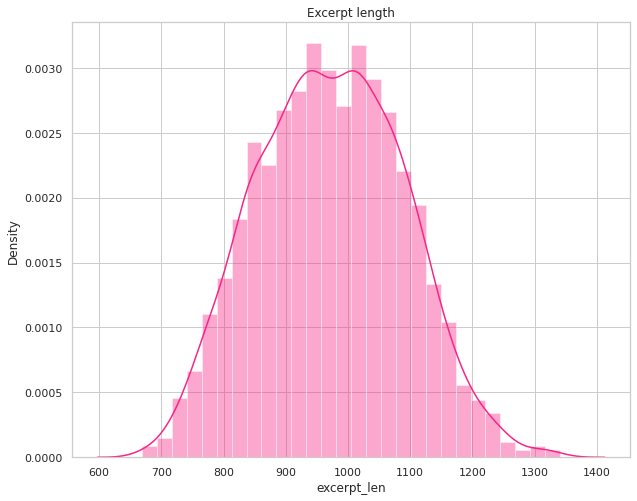

In [9]:
palette = ["#7209B7","#3F88C5","#136F63","#F72585","#FFBA08"]
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.distplot(train['excerpt_len'], ax=ax, color = palette[3]).set_title('Excerpt length')
plt.show()

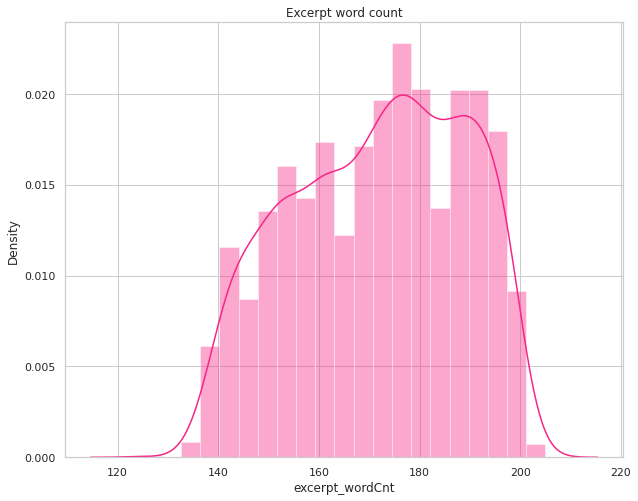

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.distplot(train['excerpt_wordCnt'], ax=ax, color = palette[3]).set_title('Excerpt word count')
plt.show()

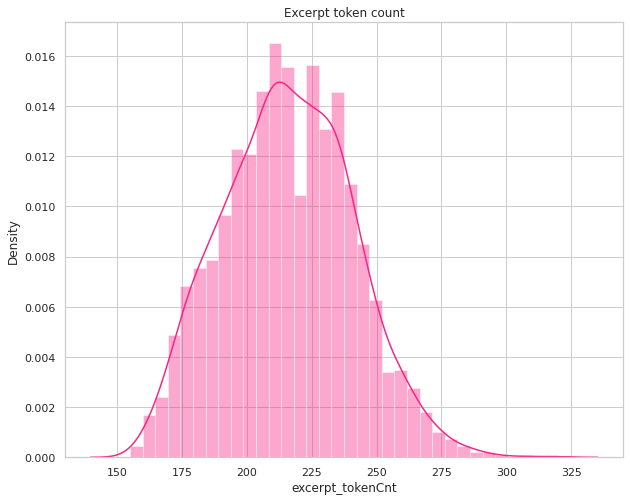

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.distplot(train['excerpt_tokenCnt'], ax=ax, color = palette[3]).set_title('Excerpt token count')
plt.show()

In [12]:
def model_fn(encoder, seq_len=256):
    input_ids = L.Input(shape=(seq_len,), dtype=tf.int32, name='input_ids')
    input_attention_mask = L.Input(shape=(seq_len,), dtype=tf.int32, name='attention_mask')
    
    outputs = encoder({'input_ids': input_ids, 
                       'attention_mask': input_attention_mask})
    
    model = Model(inputs=[input_ids, input_attention_mask], outputs=outputs)

    optimizer = optimizers.Adam(lr=LEARNING_RATE)
    model.compile(optimizer=optimizer, 
                  loss=losses.MeanSquaredError(), 
                  metrics=[metrics.RootMeanSquaredError()])
    
    return model


with strategy.scope():
    encoder = TFAutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)
    model = model_fn(encoder, SEQ_LEN)
    
model.summary()

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_roberta_for_sequence_classif TFSequenceClassifier 124646401   attention_mask[0][0]             
                                                                 input_ids[0][0]                  
Total params: 124,646,401
Trainable params: 124,646,401
Non-trainable params: 0
__________________________________________________________________________________________________


In [13]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
oof_pred = []; oof_labels = []; history_list = []; test_pred = []

for fold,(idxT, idxV) in enumerate(skf.split(train)):
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {len(idxT)} VALID: {len(idxV)}')

    # Model
    K.clear_session()
    with strategy.scope():
        encoder = TFAutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)
        model = model_fn(encoder, SEQ_LEN)
        
    model_path = f'model_{fold}.h5'
    es = EarlyStopping(monitor='val_root_mean_squared_error', mode='min', 
                       patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_root_mean_squared_error', mode='min', 
                                 save_best_only=True, save_weights_only=True)

    # Train
    history = model.fit(x=get_dataset(train.loc[idxT], tokenizer, repeated=True, is_sampled=True, 
                                      batch_size=BATCH_SIZE, seq_len=SEQ_LEN), 
                        validation_data=get_dataset(train.loc[idxV], tokenizer, ordered=True, 
                                                    batch_size=BATCH_SIZE, seq_len=SEQ_LEN), 
                        steps_per_epoch=50, 
                        callbacks=[es, checkpoint], 
                        epochs=EPOCHS,  
                        verbose=1).history
      
    history_list.append(history)
    # Save last model weights
    model.load_weights(model_path)
    
    # Results
    print(f"#### FOLD {fold+1} OOF RMSE = {np.min(history['val_root_mean_squared_error']):.4f}")

    # OOF predictions
    valid_ds = get_dataset(train.loc[idxV], tokenizer, ordered=True, batch_size=BATCH_SIZE, seq_len=SEQ_LEN)
    oof_labels.append([target[0].numpy() for sample, target in iter(valid_ds.unbatch())])
    x_oof = valid_ds.map(lambda sample, target: sample)
    oof_pred.append(model.predict(x_oof)['logits'])

    # Test predictions
    test_ds = get_dataset(test, tokenizer, labeled=False, ordered=True, batch_size=BATCH_SIZE, seq_len=SEQ_LEN)
    x_test = test_ds.map(lambda sample: sample)
    test_pred.append(model.predict(x_test)['logits'])


FOLD: 1
TRAIN: 2267 VALID: 567


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/35
50/50 [==============================] - 38s 469ms/step - loss: 1.3491 - root_mean_squared_error: 1.1600 - val_loss: 0.8925 - val_root_mean_squared_error: 0.9447
Epoch 2/35
50/50 [==============================] - 20s 412ms/step - loss: 1.0585 - root_mean_squared_error: 1.0285 - val_loss: 0.6552 - val_root_mean_squared_error: 0.8095
Epoch 3/35
50/50 [==============================] - 20s 408ms/step - loss: 0.7652 - root_mean_squared_error: 0.8719 - val_loss: 0.4290 - val_root_mean_squared_error: 0.6550
Epoch 4/35
50/50 [==============================] - 20s 410ms/step - loss: 0.6377 - root_mean_squared_error: 0.7981 - val_loss: 0.5821 - val_root_mean_squared_error: 0.7630
Epoch 5/35
50/50 [==============================] - 20s 411ms/step - loss: 0.6645 - root_mean_squared_error: 0.8148 - val_loss: 0.3832 - val_root_mean_squared_error: 0.6190
Epoch 6/35
50/50 [==============================] - 20s 409ms/step - loss: 0.6130 - root_mean_squared_error: 0.7815 - val_loss: 0.4884 

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/35
50/50 [==============================] - 39s 461ms/step - loss: 1.6430 - root_mean_squared_error: 1.2724 - val_loss: 0.7210 - val_root_mean_squared_error: 0.8491
Epoch 2/35
50/50 [==============================] - 21s 415ms/step - loss: 1.1123 - root_mean_squared_error: 1.0531 - val_loss: 0.7837 - val_root_mean_squared_error: 0.8852
Epoch 3/35
50/50 [==============================] - 20s 410ms/step - loss: 0.8745 - root_mean_squared_error: 0.9349 - val_loss: 0.4301 - val_root_mean_squared_error: 0.6558
Epoch 4/35
50/50 [==============================] - 20s 412ms/step - loss: 0.6925 - root_mean_squared_error: 0.8309 - val_loss: 0.6698 - val_root_mean_squared_error: 0.8184
Epoch 5/35
50/50 [==============================] - 21s 413ms/step - loss: 0.5847 - root_mean_squared_error: 0.7644 - val_loss: 0.5951 - val_root_mean_squared_error: 0.7714
Epoch 6/35
50/50 [==============================] - 20s 411ms/step - loss: 0.7457 - root_mean_squared_error: 0.8629 - val_loss: 0.3837 

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/35
50/50 [==============================] - 38s 464ms/step - loss: 1.5426 - root_mean_squared_error: 1.2402 - val_loss: 0.8292 - val_root_mean_squared_error: 0.9106
Epoch 2/35
50/50 [==============================] - 21s 413ms/step - loss: 1.2609 - root_mean_squared_error: 1.1214 - val_loss: 0.6043 - val_root_mean_squared_error: 0.7774
Epoch 3/35
50/50 [==============================] - 21s 413ms/step - loss: 1.0066 - root_mean_squared_error: 1.0005 - val_loss: 0.4495 - val_root_mean_squared_error: 0.6704
Epoch 4/35
50/50 [==============================] - 20s 410ms/step - loss: 0.6912 - root_mean_squared_error: 0.8297 - val_loss: 0.4887 - val_root_mean_squared_error: 0.6991
Epoch 5/35
50/50 [==============================] - 21s 414ms/step - loss: 0.6924 - root_mean_squared_error: 0.8302 - val_loss: 0.3944 - val_root_mean_squared_error: 0.6280
Epoch 6/35
50/50 [==============================] - 20s 412ms/step - loss: 0.5528 - root_mean_squared_error: 0.7374 - val_loss: 0.4093 

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/35
50/50 [==============================] - 39s 468ms/step - loss: 1.5065 - root_mean_squared_error: 1.2229 - val_loss: 0.7691 - val_root_mean_squared_error: 0.8770
Epoch 2/35
50/50 [==============================] - 20s 412ms/step - loss: 1.0508 - root_mean_squared_error: 1.0238 - val_loss: 0.4968 - val_root_mean_squared_error: 0.7048
Epoch 3/35
50/50 [==============================] - 21s 414ms/step - loss: 0.6565 - root_mean_squared_error: 0.8092 - val_loss: 0.6617 - val_root_mean_squared_error: 0.8134
Epoch 4/35
50/50 [==============================] - 20s 411ms/step - loss: 0.6832 - root_mean_squared_error: 0.8226 - val_loss: 0.5820 - val_root_mean_squared_error: 0.7629
Epoch 5/35
50/50 [==============================] - 20s 410ms/step - loss: 0.5322 - root_mean_squared_error: 0.7274 - val_loss: 0.3565 - val_root_mean_squared_error: 0.5971
Epoch 6/35
50/50 [==============================] - 21s 414ms/step - loss: 0.7041 - root_mean_squared_error: 0.8366 - val_loss: 0.5468 

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingface-roberta/roberta-base/ and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/35
50/50 [==============================] - 39s 469ms/step - loss: 1.5398 - root_mean_squared_error: 1.2374 - val_loss: 0.7509 - val_root_mean_squared_error: 0.8665
Epoch 2/35
50/50 [==============================] - 21s 414ms/step - loss: 0.9964 - root_mean_squared_error: 0.9969 - val_loss: 0.4813 - val_root_mean_squared_error: 0.6938
Epoch 3/35
50/50 [==============================] - 21s 414ms/step - loss: 0.7408 - root_mean_squared_error: 0.8599 - val_loss: 0.3943 - val_root_mean_squared_error: 0.6279
Epoch 4/35
50/50 [==============================] - 21s 416ms/step - loss: 0.9649 - root_mean_squared_error: 0.9803 - val_loss: 0.3482 - val_root_mean_squared_error: 0.5901
Epoch 5/35
50/50 [==============================] - 20s 411ms/step - loss: 0.7454 - root_mean_squared_error: 0.8626 - val_loss: 0.4025 - val_root_mean_squared_error: 0.6344
Epoch 6/35
50/50 [==============================] - 20s 413ms/step - loss: 0.5567 - root_mean_squared_error: 0.7457 - val_loss: 0.3684 


FOLD: 1


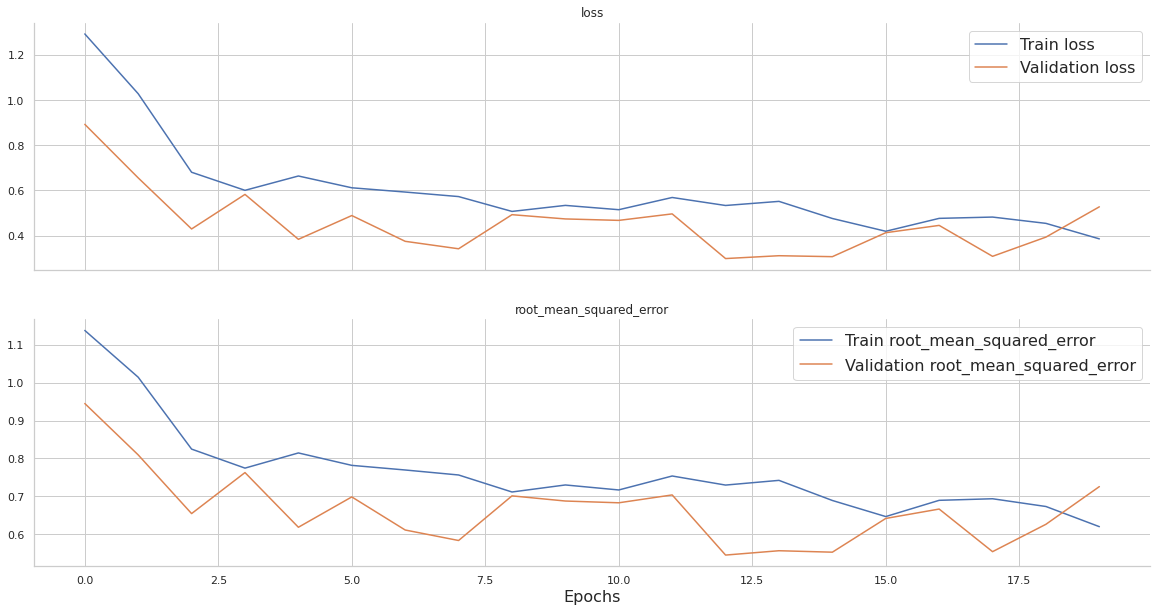


FOLD: 2


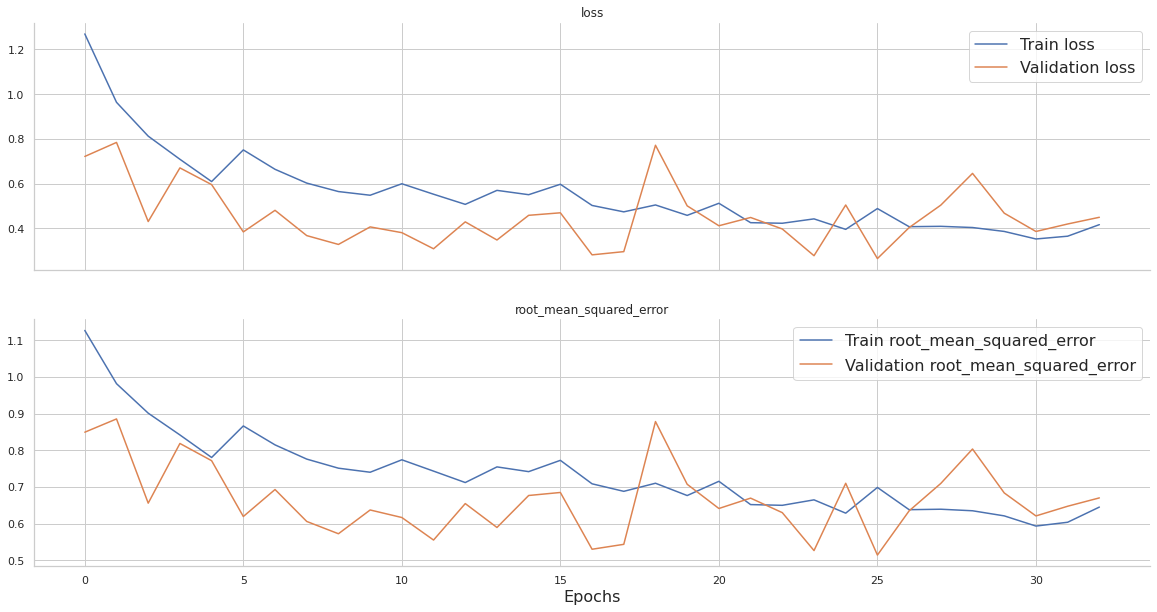


FOLD: 3


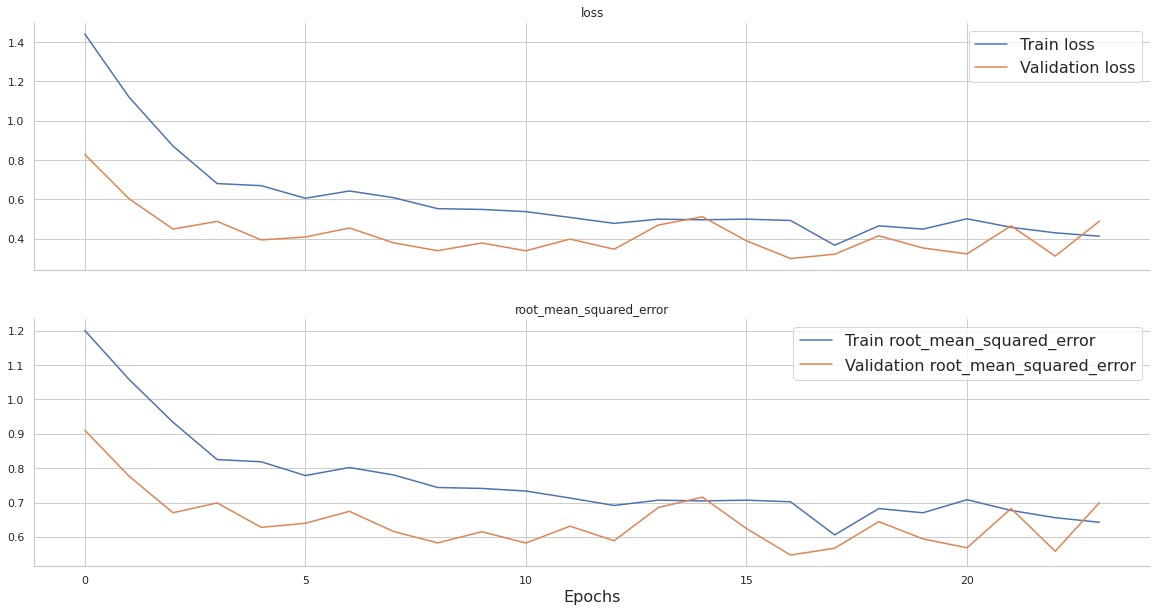


FOLD: 4


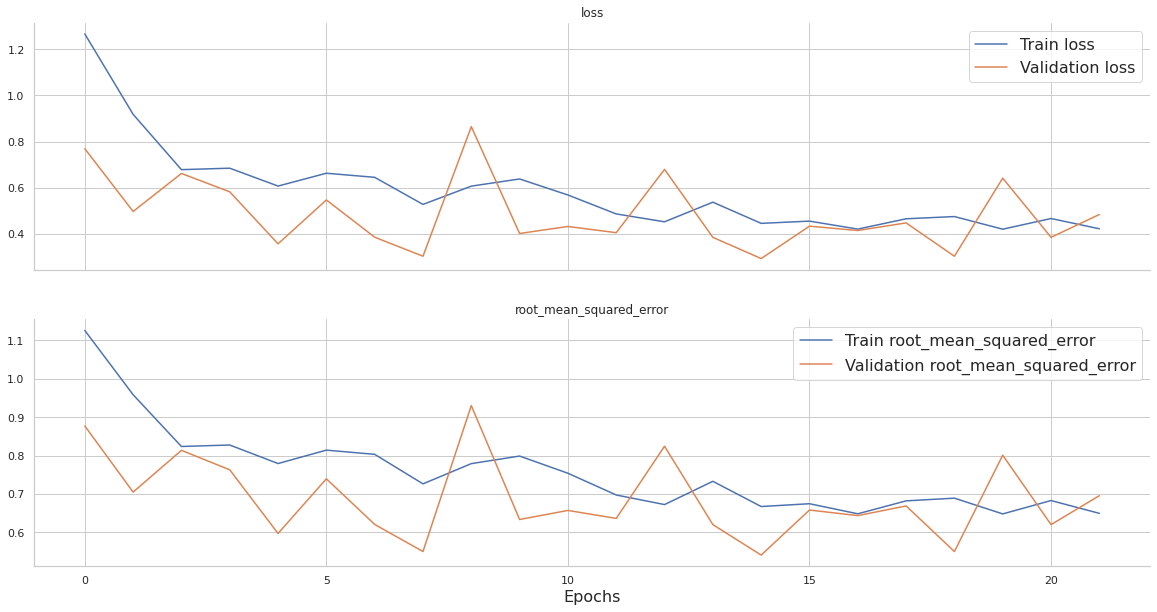


FOLD: 5


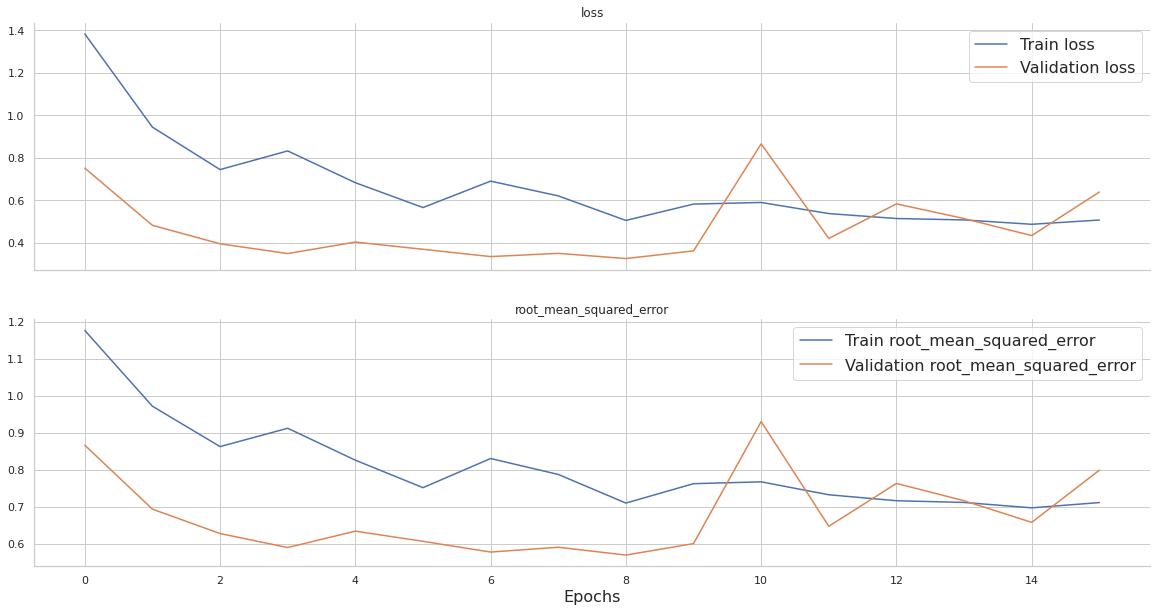

In [14]:
for fold, history in enumerate(history_list):
    print(f'\nFOLD: {fold+1}')
    plot_metrics(history)

In [15]:
y_true = np.concatenate(oof_labels)
y_preds = np.concatenate(oof_pred)


for fold, history in enumerate(history_list):
    print(f"FOLD {fold+1} RMSE: {np.min(history['val_root_mean_squared_error']):.4f}")
    
print(f'OOF RMSE: {mean_squared_error(y_true, y_preds, squared=False):.4f}')

FOLD 1 RMSE: 0.5458
FOLD 2 RMSE: 0.5143
FOLD 3 RMSE: 0.5474
FOLD 4 RMSE: 0.5409
FOLD 5 RMSE: 0.5698
OOF RMSE: 0.5439


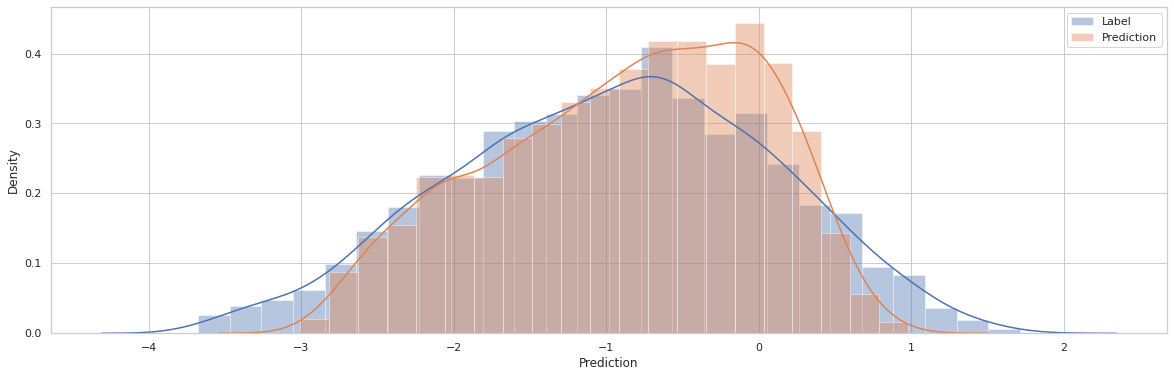

In [16]:
preds_df = pd.DataFrame({'Label': y_true, 'Prediction': y_preds[:,0]})

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(preds_df['Label'], ax=ax, label='Label')
sns.distplot(preds_df['Prediction'], ax=ax, label='Prediction')
ax.legend()
plt.show()

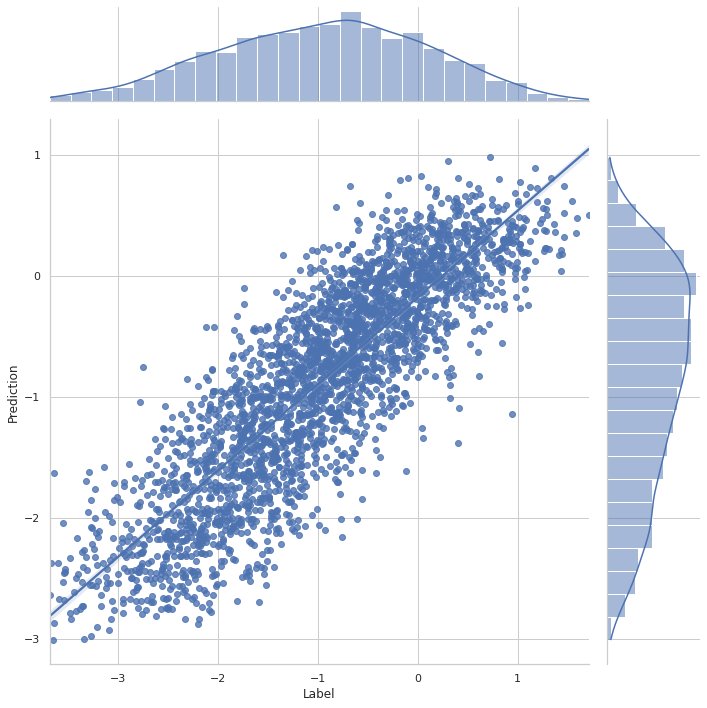

In [17]:
sns.jointplot(data=preds_df, x='Label', y='Prediction', kind='reg', height=10)
plt.show()

In [18]:
submission = test[['id']]
submission['target'] = np.mean(test_pred, axis=0)
submission.to_csv('submission.csv', index=False)
display(submission.head(10))

,id,target
0,c0f722661,-0.407942
1,f0953f0a5,-0.371701
2,0df072751,-0.359706
3,04caf4e0c,-2.393999
4,0e63f8bea,-1.672766
5,12537fe78,-1.243997
6,965e592c0,0.375395
